# Note
Thank you for taking the time to read my notebook! I write rather casually throughout this, I would be more particular with my language and code, if expected. In addition, throughout this notebook I mention additional things to consider or possibly do, but don't do them here. This was a brief example of logistic regression and random forest I was asked to do, so the process was not particularly thorough as it was time limited.

# Intro to project and data

I was asked to create a logistic regression model and a second model (for sake of time, I did a quick random forest.) 

`Modeling Dataset.csv`, which contains 30,000 customers and 53 columns. The only information on the columns is as follows:
- `target` is the dependent variable
- `record` is the unique ID for each row
- `benchmark` is a generic score for comparison, not to be used as model input
- 50 unlabelled features start with `Var_` (no definition provided)

There is also a data dictionary that gives acceptable values/ranges for the variables, including `Special Values` that are not fully described.

 
# Quick Summary

## Data cleaning and variable creation
   - The only missing values were in categorical variables, so they were given their own categorical value ("Missing").
   - No out of bounds values greater than zero, and all negative values were assumed to be special values, even if out of bounds. 
   - Special values were assumed to be one category per variable. Additional dummy variables with special (1) or not special (0) were created.
   - I considered and tested removal of features with minimal variance, but ultimately left them in.
   - A stratified test/train set were created. 
   - **Further things to consider if spending more time:** Ranges of variables, what are special variables, would any variables be dropped based on analysis or what the variable is. Also other sorts of sampling options for imbalanced data (oversampling, undersampling, SMOTE, etc.)
   
## Logistic Regression
   - L2 penalty was used.
   - Checked balanced weighting of classes for imbalanced sample, as well as grid search for weights.
   - Confusion matrix and Brier score for both, neither is perfect, so final choice seems dependent on project interest.
   - **Further things to consider if spending more time:** There are a vareity of ways to perform variable selection in logistic regression (forward selection, backward selection, other penalties, RFE...) and I simply used one here. More time could be spent exploring variables. More tuning of weights, particularly with more knowledge about what the model actually is.
   
## Random Forest
   - Picked random forest as second model, considered possible models and features.
   - Confusion matrix and Brier score for test data.
   - **Further things to consider if spending more time:** More tuning. Ideally with more time I might do a lot more exploration on what model is best, but I just picked random forest, and it wasn't a great model for this data.
   
## Comparison to benchmark and eachother
   - I cant tell quite what the benchmark is - we're asked to give percentages between 0 and 100, but they're between 0 and 1000. I'm assuming that 0 is zero, 1 is 100, and and other number should be divided by 10.
   - With that assumption, the benchmark is *really* overestimating the number of target values equal to 1. So while the logistic regression model isn't perfect, it is an improvement.
   - **Further things to consider if spending more time:** I haven't checked the quality of the benchmark, to be honest. So regardless of comparison, I don't know if that makes my models good.

# Setup

In general I like to have all of my packages imported in the same chunk of code (or since we're in a jupyter notebook, a cell). Even though I have to update as I use more packages, I like having an idea of what the notebook is doing, and keeping it separate from the actual work. I also import the datasets here. 

In [1]:
# Packages setup

#General packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Cleaning things and pipelines
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import brier_score_loss


# Logistic Regression Packages
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

#Random forests
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# Comparisons
from sklearn.metrics import f1_score
from sklearn.metrics import brier_score_loss


In [2]:
# Import datasets
df = pd.read_csv('Modeling Dataset.csv')
ddict = pd.read_csv('Modeling_exercise_data_dictionary.csv')

# Data Exploration/Cleaning

In my experience, this process can take hours all on its own. There's a lot of nuances that can be addressed: errors, imputing, new variable creation, etc. So, I'm going to go over some general ideas.

## Preliminaries to think about:

### How are values treated if they are missing
- This is the sort of thing I would want further context for. Some variables are better given means, medians, noted as missing, depending on what they are. Is it missing at random, or not?
- Variables with more than a certain percentage of missing values will be removed
- Rows with more that a certain percentage of missing values will be removed
- For categorical variables (or values that are easily switched to a categorical format), we can give missing values a unique variable
    
    
### How are values treated if they are special values (as denoted in Modeling_exercise_data_dictionary.csv)
- I'm not certain what is meant by this. For non-categorical variables, I will create a new column indicating that they have a special value. Categorical variables will not require a new column, since the category should take into account whatever is special about the variable. 

### How are values treated if they are out of bounds (not in the defined ranges, please refer to the Modeling_exercise_data_dictionary.csv to identify valid boundaries)
- My assumption is that a variable that is out of bounds is not usable. It will be treated like a missing value, as described above.

### Transformations to the values
- Avoid unless necessary or helpful. Try to minimize data leakage.

## Outline of next steps

1. Treat missing values as seems reasonable.
2. Treat out of bounds values.
3. Create binary variables for special values if needed
4. Any other transformations as needed for further modeling, removing variables with very few examples/variance

In [3]:
#### 1. Treat missing values as seems reasonable ###

# Get info about data types and nulls using info
df.info() 
# Info shows only var_876 has nulls, so I look at that
df['Var_876'].unique() 
# All of the values are object, so we can just give the missing values their own category
df['Var_876'].fillna("Missing", inplace = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 53 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Record     30000 non-null  int64  
 1   Var_79     30000 non-null  float64
 2   Var_359    30000 non-null  float64
 3   Var_430    30000 non-null  float64
 4   Var_255    30000 non-null  float64
 5   Var_927    30000 non-null  float64
 6   Var_657    30000 non-null  float64
 7   Var_623    30000 non-null  float64
 8   Var_386    30000 non-null  float64
 9   Var_876    27966 non-null  object 
 10  Var_889    30000 non-null  float64
 11  Var_782    30000 non-null  float64
 12  Var_192    30000 non-null  float64
 13  Var_687    30000 non-null  float64
 14  Var_31     30000 non-null  float64
 15  Var_712    30000 non-null  float64
 16  Var_312    30000 non-null  float64
 17  Var_289    30000 non-null  float64
 18  Var_294    30000 non-null  float64
 19  Var_706    30000 non-null  float64
 20  Var_66

In [4]:
#### 2. Treat out of bounds values ####

#Setup comparison of bounds to check maxes
dfnames = ddict['Feature Name']
dfnames = dfnames.tolist()
maxes = ddict['Max Valid Value']#.drop('Var_876')
dfmaxes = df[dfnames].max()
maxes.index = dfnames
dfmaxes = dfmaxes.drop("Var_876")
maxes = maxes.drop("Var_876")
# Check that none are greater than maxes
((maxes - dfmaxes)>= 0).sum() == len(maxes)
#Comes out as true. So no values are too large.

# Normally I'd do this in a better way, but this is quick enough
testdf = df
testdf = testdf.drop("Var_876", axis = 1)
testdf[testdf > 0] = 0
#dfnames2 = dfnames
#dfnames2.remove('Var_876')
#testdf = testdf[dfnames2]
for col in testdf:
    print(sorted(testdf[col].unique()))

# So the printout of the unique negative values doesn't totally match up.

[0]
[-5.0, -4.0, -2.0, -1.0, 0.0]
[-6.0, -4.0, -3.0, -2.0, -1.0, 0.0]
[-5.0, -4.0, -3.0, -2.0, -1.0, -0.5, 0.0]
[-4.0, -2.0, -1.0, 0.0]
[-7.0, -6.0, -1.0, 0.0]
[-6.0, -2.0, -1.0, 0.0]
[-6.0, 0.0]
[-4.0, -1.0, 0.0]
[-6.0, -2.0, -1.0, 0.0]
[-6.0, -2.0, -1.0, 0.0]
[-4.0, -2.0, 0.0]
[-6.0, -2.0, -1.0, 0.0]
[-4.0, -1.0, 0.0]
[-6.0, -2.0, -1.0, 0.0]
[-5.0, -4.0, -1.0, 0.0]
[-4.0, -2.0, -1.0, 0.0]
[-4.0, -1.0, 0.0]
[-6.0, -2.0, -1.0, 0.0]
[-6.0, -2.0, -1.0, 0.0]
[-6.0, -1.0, 0.0]
[-6.0, -2.0, -1.0, 0.0]
[-6.0, -2.0, -1.0, 0.0]
[-6.0, -2.0, -1.0, 0.0]
[-5.0, -4.0, -1.0, 0.0]
[-4.0, -2.0, -1.0, 0.0]
[-4.0, -3.0, -2.0, -1.0, 0.0]
[-9.0, -6.0, -2.0, -1.0, 0.0]
[-4.0, -2.0, -1.0, 0.0]
[-5.0, -4.0, -2.0, -1.0, 0.0]
[-4.0, 0.0]
[-6.0, -2.0, -1.0, 0.0]
[-6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0]
[-4.0, -3.0, -2.0, -1.0, 0.0]
[-6.0, -2.0, -1.0, 0.0]
[-6.0, -2.0, -1.0, 0.0]
[-7.0, -6.0, -1.0, 0.0]
[-6.0, -2.0, -1.0, 0.0]
[-6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0]
[-4.0, -3.0, -2.0, -1.0, 0.0]
[-4.0, -1.0,

As noted above, the unique negative values (IE, below bounds) given in the dataframe don't totally match up with those given. I've looked at these in a few different ways (code not included because it was quickly exploratory and a bit messy), and there's a few columns with discrepancies, defined as containing negative values that aren't the special values. But truthfully, I'm not sure what's best to do with these anyway. The data itself could have typos (particularly that 0.5), but I wonder if some are typos in the list of special values. Since I'll have to deal with all the "special values" in a similar way anyway, I'm just going to call this good enough for now.

I'm going to just create an additional binary variable correspondingly to each variable (except the one that has no negative values) that is 1 for any negative values. 

In [5]:
#### 3. Create binary values for special variables, other things ####
## Create binary for negative values, 1 if negative
for col in df:
  if col == "Var_876" or col == "benchmark" or col == "record" or col == "target": 
        pass
  else:  df[col + "_binary"] = np.where(df[col]>=0,0,1)
    
## Create dummy variables for Var_876
df["Var_876"].nunique()
df = df.set_index('Record')
pd.get_dummies(df, prefix=['Var_876'], columns=['Var_876'])
# Then drop the original since not all models can use categories
df = df.drop("Var_876", axis =1)
# Final df with all variables
df['benchmark'] = df['benchmark']/10
dfcleanfull = df

# Drop benchmark for now (can't have it in the model)
df = df.drop("benchmark", axis =1)

In [6]:
#### 4. Removing features with minimal variance/examples (decided against)

#### First we define a function so we don't lose the column titles
def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

# I poked around with this a bit, and ultimately decided a threshold of 0.01 was an okay start
# This should remove binary variables with less than 1 percent of values being unique
#short = variance_threshold_selector(df, 0.01)

#Removes 8 variables
#print(len(dfcleanfull.columns))
#print(len(short.columns))

In [7]:
#### Setup test and train ####
#Since we have so few observed positive responses, I want to ensure that we have equal proportions in the test and train set
(sum(df['target'])/len(df)*100) #Only 4.36 of "target" is 1.

#So I'm going to stratify the test and train test just to be safe
y = dfcleanfull['target']
X = df.drop('target', axis = 1)
#skf = StratifiedKFold(n_splits=2)
#skf.split(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.50,
                                                   random_state = 42)

#Check
sum(y_test)/len(y_test)
#Success

#Backup
Xtr = X_train
ytr = y_train
Xte = X_test
yte = y_test

In [8]:
scaler = MinMaxScaler()
scaler.fit(X_train)    
X_trainscale = scaler.transform(X_train)
X_trainscale_df = pd.DataFrame(X_trainscale, columns = X_train.columns)
#X_trainscale_df.head()
X_testscale = scaler.transform(X_test)
X_testscale_df = pd.DataFrame(X_testscale, columns = X_test.columns)
#X_testscale_df.head()

#redefine our train and test as scaled
X_train = X_trainscale_df
X_test = X_testscale_df

#y is binary so no change

# Logistic Regression

There's a lot of ways to think about variable selection (L1 or L2 penalties, forward or backward selection, RFE...). I've decided to just use L2, as it is more computationally feasible with this dataset.

In [9]:
#Logistic Regression with balanced class weights
lr2 = LogisticRegression(random_state=0,max_iter = 10000,solver='newton-cg',penalty = "l2", class_weight = 'balanced').fit(X_train, y_train)
print(lr2.score(X_test, y_test))
#class_weight = 'balanced'
y_predict = lr2.predict(X_test)
print(confusion_matrix(y_test, y_predict))
brier_score_loss(y_test,y_predict)

# This penalty and setup runs best, ideally I'd tune this more too.

0.7284666666666667
[[10491  3855]
 [  218   436]]


0.27153333333333335

While balanced helps (it was a useless fit without it), let's tune the weights a bit to make it even better.

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


Text(0.5, 1.0, 'Scoring for different class weights')

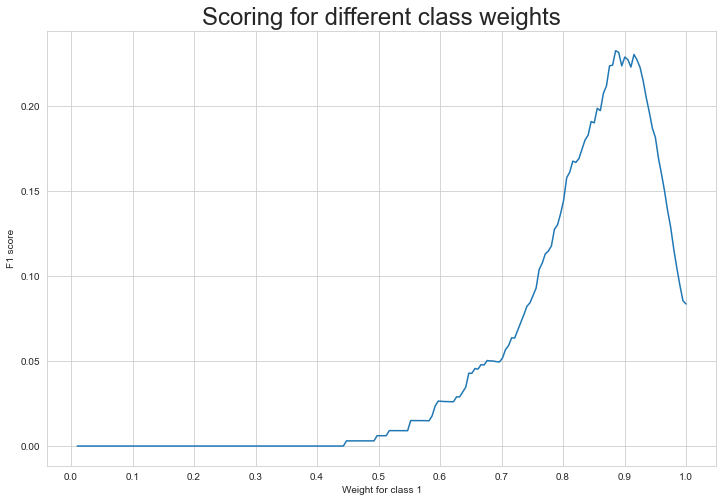

In [10]:
# While I was familiar with tuning weights via a grid search, this code only is slightly altered from here:
# https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
# And makes a very nice graph, tunes based on F1 score
# Accessed on 10/16/22

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

lr = LogisticRegression(random_state =0, max_iter = 10000, penalty = "l2", solver = "newton-cg")

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(x = weigh_data['weight'],y = weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [11]:
# Get max weight
weigh_data.loc[weigh_data['score'].idxmax()]

score     0.232494
weight    0.885578
Name: 23, dtype: float64

In [12]:
lrfinal = LogisticRegression(solver='newton-cg', class_weight={0:(1- 0.885578), 1: 0.885578})
lrfinal.fit(X_train, y_train)


LogisticRegression(class_weight={0: 0.11442200000000002, 1: 0.885578},
                   solver='newton-cg')

In [13]:
#Final confusion matrix and score
y_predict = lrfinal.predict(X_test)
print(confusion_matrix(y_test, y_predict))
brier_score_loss(y_test,y_predict)

[[13516   830]
 [  502   152]]


0.0888

In [14]:
#Try polynomial features for kicks
poly = PolynomialFeatures(degree = 2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X_train)
lr = LogisticRegression(max_iter = 10000, class_weight = "balanced")
lr.fit(X_poly,y_train)
X_poly_test = poly.fit_transform(X_train)
lr.score(poly.transform(X_test), y_test)

#Doesn't really help.
y_predict = lr.predict(poly.transform(X_test))
print(confusion_matrix(y_test, y_predict))


[[11739  2607]
 [  370   284]]


# Random Forest

A second model is not requested for the Featurespace project, and I would like to reiterate that this model is not suitable here. In a work setting, I would continue to search for a more suitable model (assuming the logistic regression wasn't acceptable for some reason).

In [15]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100,class_weight="balanced")

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

y_predict = clf.predict(X_test)
print(confusion_matrix(y_test, y_predict))
brier_score_loss(y_test,y_predict)

Accuracy: 0.953
[[14288    58]
 [  647     7]]


0.047

Fitting 5 folds for each of 50 candidates, totalling 250 fits


Text(0.5, 1.0, 'Scoring for different class weights')

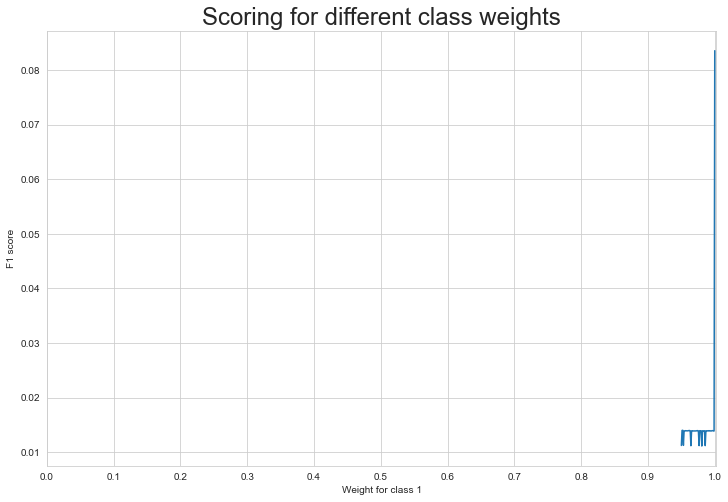

In [16]:
# While I was familiar with tuning weights via a grid search, this code is only slightly altered from here:
# https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
# And makes a very nice graph, tunes based on F1 score
# Accessed on 10/16/22

#Setting the range for class weights
#This was originally more spread out but I narrowed it down
weights = np.linspace(0.0,0.05,50)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

clf=RandomForestClassifier(n_estimators=100)

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= clf, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(x = weigh_data['weight'],y = weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [17]:
# Looking at weigh data, picking 0.954082
weigh_data

,score,weight
0,0.083557,1.000000
1,0.013891,0.998980
2,0.013891,0.997959
3,0.013950,0.996939
4,0.013949,0.995918
5,0.013891,0.994898
6,0.013891,0.993878
7,0.013949,0.992857
8,0.013891,0.991837
9,0.013949,0.990816


In [18]:
# This just doesn't work for this.
clfgrid = RandomForestClassifier(n_estimators=100,class_weight={0:(1- 0.954082), 1: 0.954082})
#clfgrid = RandomForestClassifier(n_estimators=100,class_weight={0:0.000001, 1: 1-0.000001})
clfgrid.fit(X_train,y_train)

y_predict = clfgrid.predict(X_test)
print(confusion_matrix(y_test, y_predict))
brier_score_loss(y_test,y_predict)

[[14291    55]
 [  648     6]]


0.04686666666666667

# Comparison to Benchmark


I'm not certain how the benchmark was made, and since it wasn't necessarily set to optimize F1 score, we can compare Briers score (both for separate and individual) and confusion matrix. Also, I suppose I'll throw the model on the entire dataset, even though it trained on that data, just for numerical comparison. I also could have compared the ratios.

I can't actually tell what the benchmark is doing. I assume that a benchmark greater than 500 (or .5) predicts a 1. In that case, it is predicting *a lot* of ones.


In [19]:
# Back to our original dataset to look at the benchmark
dfbase = pd.read_csv('Modeling Dataset.csv')
brier_score_loss(dfbase['target'],dfbase['benchmark']/1000)
#0.43254978613333334
dfbase['round_predict'] = round(dfbase['benchmark']/1000)
print(sum(dfbase['round_predict']),'is the benchmark 1 rate I think.')



28614.0 is the benchmark 1 rate I think.


Let's compare that to the full dataset info for the logistic model. I'm just going to ignore the random forest model, it isn't good. If I had more time I'd figure out something better, but it was just a quick attempt.

In [20]:
frames = [X_test, X_train]
X = pd.concat(frames)
frames = [y_test, y_train]
y = pd.concat(frames)

# Logistic regression redux
lrfinal = LogisticRegression(solver='newton-cg', class_weight={0:(1- 0.885578), 1: 0.885578})
lrfinal.fit(X_train, y_train)
y_predict = lrfinal.predict(X)
print(confusion_matrix(y, y_predict))
brier_score_loss(y,y_predict)


[[27109  1583]
 [  948   360]]


0.08436666666666667

In [21]:
# for logistic
print(f1_score(y, y_predict))
print(f1_score(y, y_predict, average='macro'))
print(f1_score(y, y_predict, average='micro'))
print(f1_score(y, y_predict, average='weighted'))

0.22147031682559215
0.588435205990727
0.9156333333333333
0.923400756820662


In [22]:
# for benchmark
y = dfbase['target']
y_predict = dfbase['round_predict']
print(f1_score(y, y_predict))
print(f1_score(y, y_predict, average='macro'))
print(f1_score(y, y_predict, average='micro'))
print(f1_score(y, y_predict, average='weighted'))
print(confusion_matrix(y, y_predict))

0.0729229329590268
0.07532708254441134
0.07533333333333334
0.07752159028595033
[[ 1169 27523]
 [  217  1091]]


Ah, the benchmark is quite bad! Now that I've finally looked at the confusion matrix, I see that it is *vastly* overpredicting 1 values. It correspondingly *does* catch more of them than my logistic regression model, but at the cost of predicting them much more often than they actually occur. So overall, my model isn't so bad. I think it really depends on what the goals of the model are, and what we want to do. I also acknowledge the total failings of my second model, which should be totally redone or scrapped for a better process.